# Utilisation de SimpleITK

Dans ce travail, vous devrez créer un ou des scripts  qui permette(nt) de charger et superposer un volume TDM d'un patient et des images segmentées représentant certains organes ou tumeurs de ce patient.

Vous devrez utiliser la bibliothèque SimpleITK pour cela. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.show import show_one_by_two
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact, fixed

## Affichage des images CT et segmentées
-----------

Les images TDM du patient sont dans le répertoire `images` au format `mhd`. Les images en label sont situées dans le sous-répertoire `roi` de `images`.

In [15]:
st_image_ct = './images/ct.mhd'
st_image_label = './images/roi/body_38_2mm.mhd'
img  = sitk.ReadImage(st_image_ct)
arr_img = sitk.GetArrayFromImage(img)
img_lab = sitk.ReadImage(st_image_label)
arr_img_lab = sitk.GetArrayFromImage(img_lab)

In [21]:
interact(show_one_by_two, 
         coupe=(0,img_lab.GetDepth()-1), 
         img=fixed(arr_img),
         label=fixed(arr_img_lab));

interactive(children=(IntSlider(value=189, description='coupe', max=379), Output()), _dom_classes=('widget-int…

Visiblement, les images TDM et en label n'ont pas les mêmes dimensions. 

- Déterminer la taille des pixels de l'image CT et de l'image de label

In [23]:
img.GetSpacing(), img_lab.GetSpacing()

((2.0, 2.0, 2.0), (2.0, 2.0, 2.0))

## Ré-échantillonnage
----

Il est souvent intéressant de ré-échantillonner les images. Dans le cas présent, cela va nous permettre de superposer les images l'une sur l'autre.

Utiliser la fonction `Resample` en utilisant comme **interpolateur le plus proche voisin** et en mettant à **zéro la valeur par défaut** et comme transformation, la **transformation identitaire**.

In [24]:
# votre code ici
resample_img_lab = sitk.Resample(img_lab, img,
                                 sitk.Transform(),
                                 sitk.sitkNearestNeighbor, 0)

Vérifier que vous avez bien les mêmes dimensions pour l'image ct et l'image en label.

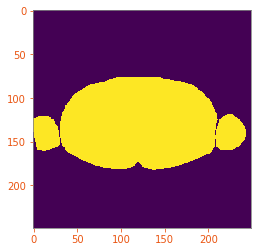

((380, 249, 249), (380, 249, 249))

In [5]:
# votre code ici
arr_ct = sitk.GetArrayFromImage(img)
arr_resampled_label = sitk.GetArrayFromImage(resample_img_lab)
plt.imshow(arr_resampled_label[189], interpolation='nearest')
plt.show()
shape_ct = arr_ct.shape
shape_ct, arr_resampled_label.shape

In [25]:
interact(show_one_by_two, 
         coupe=(0,img_lab.GetDepth()-1), 
         img=fixed(arr_img),
         label=fixed(arr_resampled_label));

interactive(children=(IntSlider(value=189, description='coupe', max=379), Output()), _dom_classes=('widget-int…

## Fusion des images CT et de labels
----------

Pour mélanger 2 images, il existe une fonction `LabelOverlay` de simpleITK qui prend en paramètre 2 images et le pourcentage d'information de l'une sur l'autre pour chacun des pixels.

Créer une fonction d'affichage qui puisse mélanger le niveau d'information d'une image sur l'autre à l'aide d'un glisseur (comme dans l'exemple précédent).

In [35]:
def my_label_show(coupe, percent):
    # votre code ici
    overlay_lab_img = sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(img),sitk.sitkUInt8), 
                                    resample_img_lab, percent)    
    arr_overlay_lab = sitk.GetArrayFromImage(overlay_lab_img)
    plt.imshow(arr_overlay_lab[coupe])
    plt.show()

In [36]:
# votre code ici
interact(my_label_show, coupe=(0, img.GetDepth()-1), percent=(0,1,0.1));

interactive(children=(IntSlider(value=189, description='coupe', max=379), FloatSlider(value=0.0, description='…

## Extraction des informations HU
---------

Avec les images en label, il est possible de tirer des informations d'images sur lesquels ces labels s'appliquent.

Pour cela, on utilise les méthodes de la classe LabelStatisticsImageFilter. L'exemple suivant extrait par exemple le nombre de voxel, le maximum, minimum, la moyenne et l'écart-type.

In [40]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img, resample_img_lab)
label = 1
print(stats.GetCount(label), stats.GetMaximum(label),
      stats.GetMinimum(label), stats.GetMean(label),
      stats.GetSigma(label))

6209454 3065.0 -1806.0 -47.74961888758657 196.16625465956906


## Chargement de plusieurs fichiers de labels
-----------

Sur la base de l'exemple précédent, faites un script qui permettent de récupérer le nombre de voxels, le volume en cm3, la valeur moyenne et maximale pour **l'ensemble des régions labelisées** qui se situent dans le répertoire `roi` 

In [124]:
# votre code ici
from pathlib import Path
import re

search_string = r'.\images\roi\*_2mm.mhd'
label_files = Path('./images').rglob('*2mm.mhd')
print("Nombre d'images : ", len(list(label_files)))

Nombre d'images :  17


In [125]:
dico_label_files = {}
chg_label = sitk.ChangeLabelImageFilter()
d_map = sitk.DoubleDoubleMap()
label_files = Path('./images').rglob('*2mm.mhd')

Les images en label contiennent soit des 0 ou 1. On souhaite créer une seule image en label qui contienne l'ensemble des labels (de 0 à N). Le label 1 devra être celui référant le label `body`. Les autres labels incrémenteront la valeur de label (> 1).

In [126]:
for i, label_file in enumerate(label_files):
    key = re.search(r'.*\\(?P<roi_name>\w+)_(?P<roi_id>\d+)_2mm.*', 
                    str(label_file)).group('roi_name')
    d_map[0] = 0
    d_map[1] = i+1
    if not re.match('.*body.*', str(label_file)):
        chg_label.SetChangeMap(d_map)
    image = sitk.Resample(sitk.ReadImage(str(label_file)), img, sitk.Transform(),
                          sitk.sitkNearestNeighbor, 0)
    image = chg_label.Execute(image)
    dico_label_files[key] = {'file': str(label_file), 'sitk_file': image, 'label_idx':i+1}

In [127]:
dico_label_files

{'body': {'file': 'images\\roi\\body_38_2mm.mhd',
  'sitk_file': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000214C9EC4540> >,
  'label_idx': 1},
 'bone_marrow': {'file': 'images\\roi\\bone_marrow_269_2mm.mhd',
  'sitk_file': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000214CB7ED600> >,
  'label_idx': 2},
 'heart': {'file': 'images\\roi\\heart_268_2mm.mhd',
  'sitk_file': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000214CC2B53C0> >,
  'label_idx': 3},
 'left_kidney': {'file': 'images\\roi\\left_kidney_865_2mm.mhd',
  'sitk_file': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x00000214CBFBCBD0> >,
  'label_idx': 4},
 'lesion01': {'file': 'images\\roi\\lesion01_866_2mm.mhd',
  'sitk_file': <SimpleITK.SimpleITK.

On crée une image vide qui partage les dimensions, l'origine et la taille des pixels de l'image CT.

In [128]:
image_sum_labels = sitk.Image(img.GetWidth(), img.GetHeight(), img.GetDepth(), sitk.sitkUInt8)
image_sum_labels.SetOrigin(img.GetOrigin())
image_sum_labels.SetSpacing(img.GetSpacing())

for label in dico_label_files:
    if not re.match('.*body.*', label):
        image_sum_labels = sitk.Add(image_sum_labels,
                                          dico_label_files[label]['sitk_file'])
image_sum_labels = sitk.Add(image_sum_labels, dico_label_files['body']['sitk_file'])
arr_tmp = sitk.GetArrayFromImage(image_sum_labels)

In [129]:
def tmp_show(coupe):
    plt.imshow(arr_tmp[coupe], cmap=plt.cm.Accent_r, interpolation='nearest')
    plt.show()

interact(tmp_show, coupe=(0, img.GetDepth()-1));

#sitk.WriteImage(image_sum_labels,'labelmap.mhd')

interactive(children=(IntSlider(value=189, description='coupe', max=379), Output()), _dom_classes=('widget-int…

In [117]:
stats_all = sitk.LabelIntensityStatisticsImageFilter()
stats_all.Execute(image_sum_labels, img)
dic_out = {}
for label in dico_label_files:
    if not 'body' in label:
        indice = dico_label_files[label]['label_idx']+1       
    else:
        indice = dico_label_files[label]['label_idx']
    nb_pixels = stats_all.GetNumberOfPixels(indice)
    mean = stats_all.GetMean(indice)
    maxi = stats_all.GetMaximum(indice)
    std = stats_all.GetStandardDeviation(indice)
    dic_out[label] = [nb_pixels, nb_pixels*(img.GetSpacing()[0]/10)**3, mean, maxi]

In [118]:
import pandas as pd
pd.DataFrame(dic_out, index=['nb_pix', 'vol_cc', 'mean', 'max']).T

nb_pix     vol_cc       mean     max
body          5818035.0  46544.280 -49.679703  3065.0
bone_marrow     18731.0    149.848  92.698361   408.0
heart           66590.0    532.720  28.618666  1150.0
left_kidney       830.0      6.640 -41.580723    60.0
lesion01         6599.0     52.792  36.247007    86.0
lesion02         1141.0      9.128  22.484663    76.0
lesion03         1600.0     12.800  33.218750    72.0
lesion04        10917.0     87.336  36.084181   103.0
lesion05         2768.0     22.144  24.204118   510.0
lesion06          502.0      4.016  23.796813    67.0
lesion07          578.0      4.624   7.858131   221.0
lesion08         1668.0     13.344  19.293165    66.0
lesion09         2096.0     16.768  28.794370    79.0
lesion10          539.0      4.312  39.217069    72.0
liver          143370.0   1146.960  55.787640   193.0
right_kidney    21388.0    171.104  21.152141   126.0
spleen          16907.0    135.256  45.547820   205.0